In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy import stats
import seaborn as sns
import os
import os.path as osp
import sys
import pickle
import joblib
from collections import Counter
from itertools import product
import torch
import pdb
import random
import tables
from sklearn.linear_model import LogisticRegression, LinearRegression
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, average_precision_score,\
balanced_accuracy_score
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.calibration import CalibratedClassifierCV
import wandb
from wandb.lightgbm import wandb_callback, log_summary
from dill.source import getsource
from dill import detect
import functools
import copy

### set the seeds and change to current directory + set the output directory

In [2]:
SEED=90210
np.random.seed(SEED)
os.environ['USER_PATH']='/share/pierson/selective_labels_data/hirid_data_analysis/richras_dir/learning_from_doctor_and_patient/'
os.environ['OUT_PATH']='/share/pierson/selective_labels_data/hirid_data_analysis/richras_dir/learning_from_doctor_and_patient/output_directory'

In [3]:
os.chdir('/share/pierson/selective_labels_data/hirid_data_analysis/richras_dir/learning_from_doctor_and_patient/')
from AnalysisFuncs import plotCorr, getPred_fromProb, getMetrics, getCorr, getGroundTruth, getURange
from AnalysisFuncs import getResiduals, plotDistributionProbs, plotCorr_w_Unobs, trainHardPseudo
from AnalysisFuncs import saveFile, loadFile

In [4]:
%reload_ext autoreload
%autoreload 2

### Create function to pickle functions

In [5]:
def function_to_string(fn):
    return getsource(detect.code(fn)) 

In [6]:
processed_data_path=osp.join(os.environ.get('OUT_PATH'), 'ParksInspection','New_Dataset')

In [7]:
train_X = loadFile(osp.join(processed_data_path,'predict_T'), '/train_X.npy')
train_y_T = loadFile(osp.join(processed_data_path,'predict_T'), '/train_y_T.npy')
val_X = loadFile(osp.join(processed_data_path,'predict_T'), '/val_X.npy')
val_y_T = loadFile(osp.join(processed_data_path,'predict_T'), '/val_y_T.npy')
train_cross_val_X = loadFile(osp.join(processed_data_path,'predict_T'), '/train_cross_val_X.npy')
train_cross_val_y_T = loadFile(osp.join(processed_data_path,'predict_T'), '/train_cross_val_y_T.npy')
test_X = loadFile(osp.join(processed_data_path,'predict_T'), '/test_X.npy')
test_y_T = loadFile(osp.join(processed_data_path,'predict_T'), '/test_y_T.npy')

train_X_D_given_T = loadFile(osp.join(processed_data_path,'predict_D_given_T'), '/train_X_D_given_T.npy')
train_y_D_given_T = loadFile(osp.join(processed_data_path,'predict_D_given_T'), '/train_y_D_given_T.npy')
val_X_D_given_T = loadFile(osp.join(processed_data_path,'predict_D_given_T'), '/val_X_D_given_T.npy')
val_y_D_given_T = loadFile(osp.join(processed_data_path,'predict_D_given_T'), '/val_y_D_given_T.npy')
train_cross_val_X_D_given_T = loadFile(osp.join(processed_data_path,'predict_D_given_T'), 
                                       '/train_cross_val_X_D_given_T.npy')
train_cross_val_y_D_given_T = loadFile(osp.join(processed_data_path,'predict_D_given_T'), 
                                       '/train_cross_val_y_D_given_T.npy')
test_X_D_given_T = loadFile(osp.join(processed_data_path,'predict_D_given_T'), '/test_X_D_given_T.npy')
test_y_D_given_T = loadFile(osp.join(processed_data_path,'predict_D_given_T'), '/test_y_D_given_T.npy')



train_y_D_and_T = loadFile(osp.join(processed_data_path,'predict_D_and_T'), '/train_y_D_and_T.npy')
val_y_D_and_T = loadFile(osp.join(processed_data_path,'predict_D_and_T'), '/val_y_D_and_T.npy')
train_cross_val_y_D_and_T = loadFile(osp.join(processed_data_path,'predict_D_and_T'), 
                                       '/train_cross_val_y_D_and_T.npy')
test_y_D_and_T = loadFile(osp.join(processed_data_path,'predict_D_and_T'), '/test_y_D_and_T.npy')

In [8]:
# load df_cleaned and test_idxs
df_cleaned = loadFile(processed_data_path, 'df_cleaned.csv')


/home/rr568/.conda/envs/icu-benchmark/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  if await self.run_code(code, result, async_=asy):


In [9]:
for col in df_cleaned.columns:
    weird = (df_cleaned[[col]].applymap(type) != df_cleaned[[col]].iloc[0].apply(type)).any(axis=1)
    if len(df_cleaned[weird]) > 0:
        print(col)

BoroughCode
SRCommunityBoardCleaned


In [10]:
pd.api.types.infer_dtype(df_cleaned['BoroughCode']), pd.api.types.infer_dtype(df_cleaned['SRCommunityBoardCleaned'])

('string', 'mixed')

In [11]:
weird = (df_cleaned[['SRCommunityBoardCleaned']].applymap(type) != df_cleaned[['SRCommunityBoardCleaned']].iloc[0].apply(type)).any(axis=1)
df_cleaned[['SRCommunityBoardCleaned']][weird]

,SRCommunityBoardCleaned
114688,315.0
114689,305.0
114690,316.0
114691,301.0
114692,412.0
...,...
131067,310.0
131068,401.0
131069,503.0
131070,313.0


In [12]:
# df_sf = loadFile(processed_data_path, 'processed_df.csv')
features = loadFile(processed_data_path, 'features.pkl')
test_idxs = loadFile(processed_data_path, '/test_idxs.npy')
train_idxs = loadFile(processed_data_path, '/train_idxs.npy')
val_idxs = loadFile(processed_data_path, '/val_idxs.npy')
assert len(np.intersect1d(train_idxs, val_idxs))==0
assert len(np.intersect1d(test_idxs, val_idxs))==0
assert len(np.intersect1d(train_idxs, test_idxs))==0
tr=len(train_idxs)
v=len(val_idxs)
t=len(test_idxs)
print(f"train %:{tr*100/(tr+v+t):.2f}, val %:{v*100/(tr+v+t):.2f}, test %:{t*100/(tr+v+t):.2f}")

train %:64.01, val %:15.99, test %:19.99


In [13]:
#use isotonic regression for calibration in the path to save the model
calibrate_method='sigmoid'
processed_data_path = osp.join(processed_data_path, calibrate_method)

In [14]:
# load the models
LR_T = loadFile(osp.join(processed_data_path,'predict_T'),'LR_T.pkl')
LGBM_T = loadFile(osp.join(processed_data_path,'predict_T'),'LGBM_T.pkl')

LR_D_given_T = loadFile(osp.join(processed_data_path,'predict_D_given_T'),'LR_D_given_T.pkl')
LGBM_D_given_T = loadFile(osp.join(processed_data_path,'predict_D_given_T'),'LGBM_D_given_T.pkl')

LR_D_and_T = loadFile(osp.join(processed_data_path,'predict_D_and_T'),'LR_D_and_T.pkl')
LGBM_D_and_T =loadFile(osp.join(processed_data_path,'predict_D_and_T'),'LGBM_D_and_T.pkl')

LR_D_given_T_ipw = loadFile(osp.join(processed_data_path,'predict_D_given_T_ipw'),'LR_D_given_T_ipw.pkl')
LGBM_D_given_T_ipw = loadFile(osp.join(processed_data_path,'predict_D_given_T_ipw'),'LGBM_D_given_T_ipw.pkl')

LR_D_pseudo = loadFile(osp.join(processed_data_path,'predict_D_pseudo'),'LR_D_pseudo.pkl')
LGBM_D_pseudo = loadFile(osp.join(processed_data_path,'predict_D_pseudo'),'LGBM_D_pseudo.pkl')

In [15]:
df_cleaned.head()

,index,SRtypeCleaned,SRCategoryCleaned,SRSourceCleaned,BoroughCode,SRCommunityBoardCleaned,SRPriority,Descriptor1Cleaned,hanging_blocking_dummy,year_month_reports,...,frac_public_assistance,frac_rented,logmedianhouseholdincome,logdensity,census_tract,INSPcreated,high_risk_label,T,D,D_and_T
0,0,Limb Down - Sidewalk,Hazard,3-1-1 Call Center,Brooklyn,318.0,Routine,Branch or Limb Has Fallen Down,0,7919,...,0.074742,0.309278,11.368235,0.007161,3.604707e+11,1,0.0,1,0.0,False
1,1,Street Tree,Plant Tree,Department of Parks and Recreation - Public We...,Queens,406.0,Routine,For One Address,0,4161,...,0.155738,0.350410,11.098349,0.008272,3.608107e+11,0,NaN,0,NaN,False
2,2,Dead Tree Older Than 2 Years,Remove Tree,3-1-1 Call Center,Brooklyn,306.0,Routine,Planted More Than 2 Years Ago,0,7183,...,0.055556,0.628968,12.025354,0.006728,3.604701e+11,1,0.0,1,0.0,False
3,3,Street Tree,Plant Tree,Department of Parks and Recreation - Public We...,Brooklyn,302.0,Routine,For One Address,0,6710,...,0.000000,0.471074,11.738179,0.007144,3.604700e+11,0,NaN,0,NaN,False
4,4,Dead Tree Older Than 2 Years,Remove Tree,3-1-1 Call Center,Staten Island,501.0,Routine,Planted More Than 2 Years Ago,0,7607,...,0.000000,0.195592,12.047915,0.007697,3.608501e+11,0,NaN,0,NaN,False


In [16]:
test_idxs

array([     2,      4,      5, ..., 209750, 209758, 209762])

auc_score:0.963
auc_score:0.963
classification report for model LGBM, task T: 
               precision    recall  f1-score   support

           0       0.87      0.86      0.86     21365
           1       0.86      0.86      0.86     20576

    accuracy                           0.86     41941
   macro avg       0.86      0.86      0.86     41941
weighted avg       0.86      0.86      0.86     41941

auc_score:0.687
auc_score:0.687
classification report for model LGBM, task D|T: 
               precision    recall  f1-score   support

         0.0       0.66      0.66      0.66     12759
         1.0       0.44      0.44      0.44      7817

    accuracy                           0.57     20576
   macro avg       0.55      0.55      0.55     20576
weighted avg       0.57      0.57      0.57     20576

auc_score:0.681
auc_score:0.681
classification report for model LGBM, task D|T_ipw: 
               precision    recall  f1-score   support

         0.0       0.66      0.66      0.66

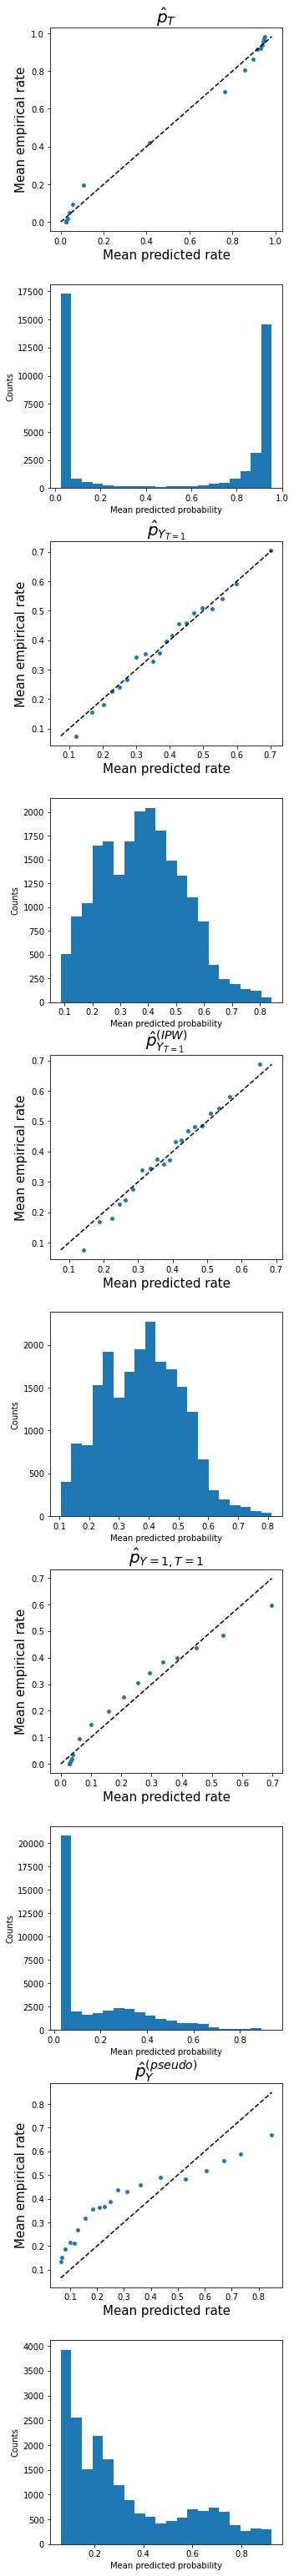

T and D|T probs for model LGBM: (0.5427645166510083, 0.0)
T and D,T probs for model LGBM: (0.7551163196744328, 0.0)
D,T and D|T probs for model LGBM: (0.8589028573799925, 0.0)


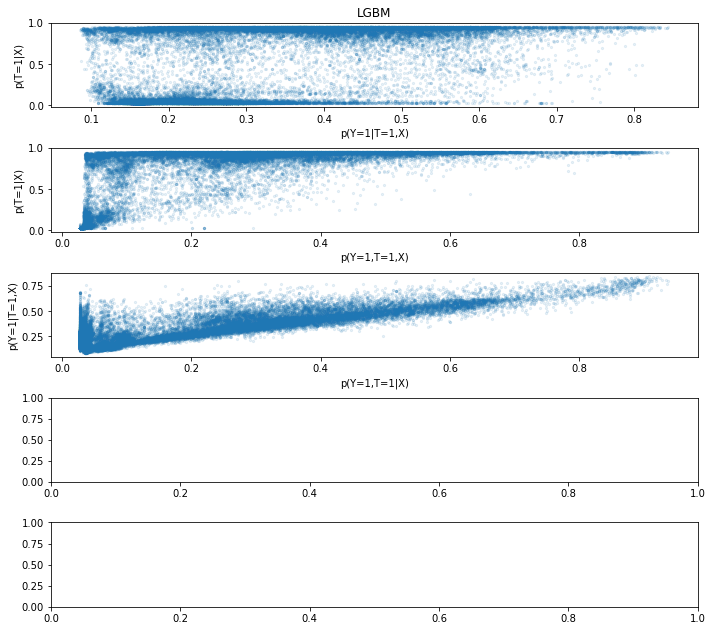

In [17]:
models=['LGBM']
tasks=['T', 'D|T', 'D|T_ipw', 'D_and_T','D_pseudo']
# clf_list=[LR_T, LGBM_T, LR_D_given_T, LGBM_D_given_T, LR_D_given_T_ipw, LGBM_D_given_T_ipw,
#           LR_D_and_T, LGBM_D_and_T, LR_D_pseudo, LGBM_D_pseudo]
clf_list=[LGBM_T, LGBM_D_given_T, LGBM_D_given_T_ipw,
          LGBM_D_and_T, LGBM_D_pseudo]
clf_dict={}
i=0
for t in tasks:
    clf_dict[t]={}
    for m in models:
        clf_dict[t][m]=clf_list[i]
        i+=1
dict_df_labels={}
dict_df_probs={}
dict_df_ids={}
dict_models={}
probs_path=processed_data_path
alpha=0.1
figsize1=(5,50)
figsize2=(10,10)
df_pp=pd.DataFrame({'AUC' : [],'PR':[],'BalancedAcc':[],'modelName':[],'rowName':[]})
dict_df_labels, dict_df_probs, dict_models, df_pp = getCorr(models, tasks, test_X.copy(), clf_dict, df_cleaned.copy(), 
        test_idxs, dict_df_labels, dict_df_probs, dict_models, df_pp, probs_path, calibrate=False, 
        figsize1=figsize1, figsize2=figsize2, alpha=alpha)


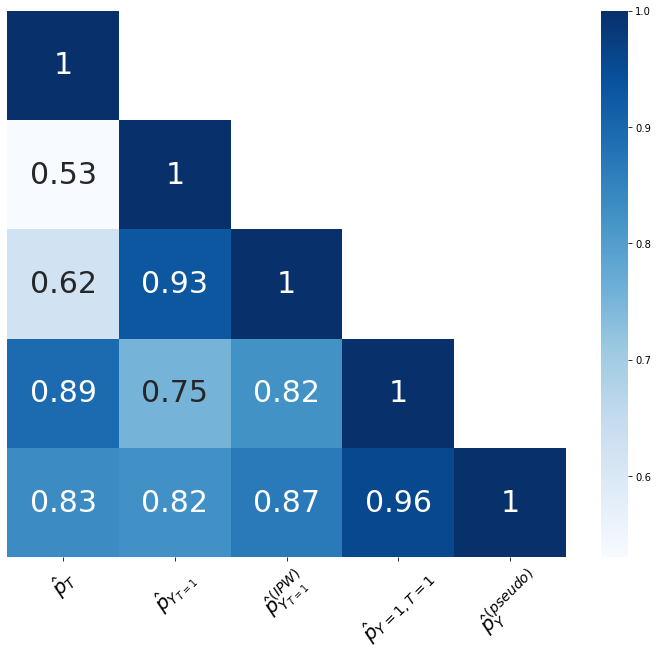

In [18]:
title='correlation matrix'
corr_method="spearman"
figsize=(10, 10)
top_adjust=0.9
title_en=False
plotCorr(models, dict_df_probs, title, corr_method, figsize=figsize, top_adjust=top_adjust,
         title_en=title_en, savefig_path=processed_data_path)

lines did not cross


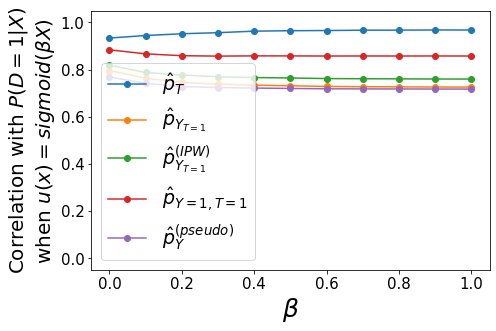

In [19]:
title=r'Correlation with $P(D=1|X)$' '\n' r'when $u(x)=sigmoid(\beta X)$'
# models=['LogisticRegression', 'LGBM']
models=['LGBM']
# tasks=['T', 'D|T', 'D|T_ipw', 'D_and_T', 'product_T_D_given_T', 'D_pseudo']
tasks=['T', 'D|T', 'D|T_ipw', 'D_and_T','D_pseudo']
figsize=(7,5)
# figsize=(10,7)
top_adjust=0.9
# tasks=['T', 'D|T']
corr_method=stats.pearsonr
title_en=True
plotCorr_w_Unobs(dict_df_probs, models, title, tasks, alpha=['sigmoid'],X=test_X, corr_method=corr_method,
                 figsize=figsize, top_adjust=top_adjust, title_en=title_en)

In [20]:
test_X.shape

(41941, 337)

lines did not cross


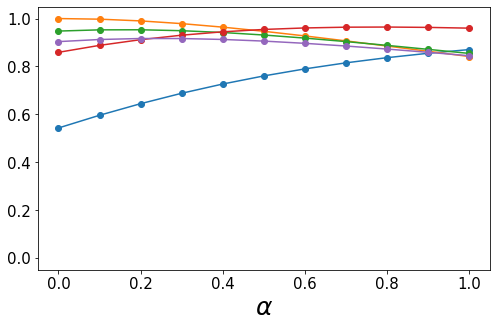

In [21]:
title=r'Correlation with $P(D=1|X)$' '\n' r'when $u(x)=\alpha P(D=1|T=1,X)$'
# models=['LogisticRegression', 'LGBM']
models=['LGBM']
# tasks=['T', 'D|T', 'D|T_ipw', 'D_and_T', 'product_T_D_given_T', 'D_pseudo']
tasks=['T', 'D|T', 'D|T_ipw', 'D_and_T','D_pseudo']
figsize=(7,5)
# figsize=(10,7)
top_adjust=0.9
# tasks=['T', 'D|T']
corr_method=stats.pearsonr
title_en=False
plotCorr_w_Unobs(dict_df_probs, models, title, tasks, alpha=np.arange(0,1.1,0.1), corr_method=corr_method,
                 figsize=figsize, top_adjust=top_adjust, title_en=title_en, savefig_path=processed_data_path)

lines did not cross
[[1.      0.53031]
 [0.53031 1.     ]], spearman from lib:SpearmanrResult(correlation=0.5303099977668304, pvalue=0.0), var of D:146590783.0341321, var of T :146590783.31415117
 the point of crossover would be :0.34096641758482377 with std for p_D_T1:0.14547325260474112 and std for p_T:0.42664979629130506


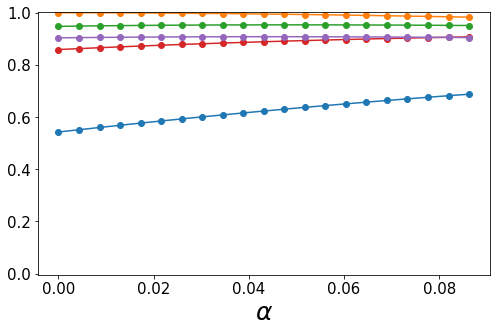

In [22]:
title=r'Correlation with $P(D=1|X)$' '\n' r'when $u(x)=\alpha$ is constant'
models=['LGBM']
# tasks=['T', 'D|T']
corr_method=stats.pearsonr
tasks=['T', 'D|T', 'D|T_ipw', 'D_and_T','D_pseudo']
figsize=(7,5)
# figsize=(10,7)
title_en=False
plotCorr_w_Unobs(dict_df_probs, models, title, tasks, corr_method=corr_method,
                 figsize=figsize, title_en=title_en, savefig_path=processed_data_path)

In [23]:
df_probs_stats=pd.DataFrame({'model' : [],'task':[],'mean':[],'std':[], 'min':[]})
for m in models:
    for t in tasks:
        df_probs_stats=df_probs_stats.append({'model' : m,'task':t,'mean':dict_df_probs[m][t].mean(),
                               'std':dict_df_probs[m][t].std(), 'min':dict_df_probs[m][t].min()},ignore_index=True)
        print(f" mean and std for model {m} and task {t}: {dict_df_probs[m][t].mean():.3f}, {dict_df_probs[m][t].std():.3f}")

 mean and std for model LGBM and task T: 0.493, 0.427
 mean and std for model LGBM and task D|T: 0.313, 0.145
 mean and std for model LGBM and task D|T_ipw: 0.309, 0.138
 mean and std for model LGBM and task D_and_T: 0.188, 0.198
 mean and std for model LGBM and task D_pseudo: 0.211, 0.222


In [24]:
df_probs_stats

,model,task,mean,std,min
0,LGBM,T,0.493043,0.426655,0.025111
1,LGBM,D|T,0.313342,0.145475,0.086282
2,LGBM,D|T_ipw,0.309346,0.137511,0.102717
3,LGBM,D_and_T,0.188152,0.197666,0.028498
4,LGBM,D_pseudo,0.211092,0.222177,0.062097


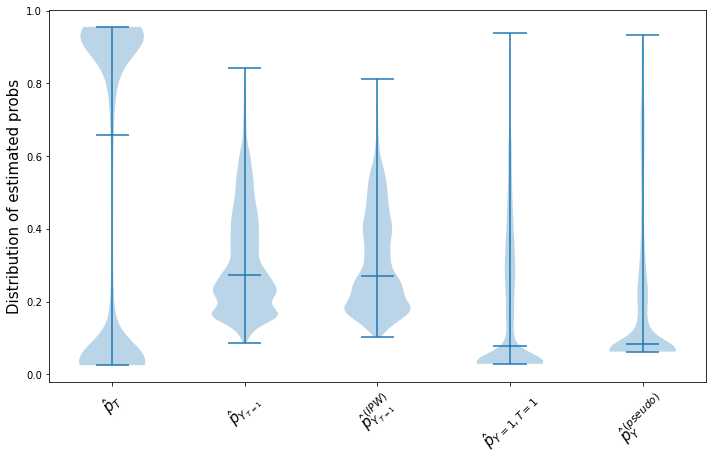

In [25]:
title='Distribution of estimated probs'
models=['LGBM']
tasks=['T', 'D|T', 'D|T_ipw', 'D_and_T', 'D_pseudo']
figsize=(10,7)
plotDistributionProbs(dict_df_probs, models, title, tasks, figsize=figsize)

for model :LGBM


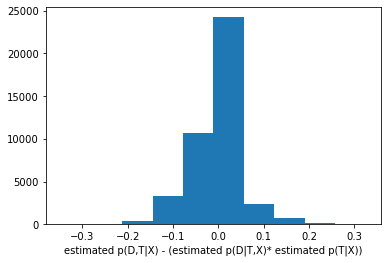

In [26]:
for m in models:
    print(f"for model :{m}")
    getResiduals(dict_df_probs[m]['D_and_T'], dict_df_probs[m]['D|T'], dict_df_probs[m]['T'])

#### Equity
Patition the data by the median of frac_white. Compute P(above median frac black|high risk). We do this for frac_black, frac_white, frac_hispanic and avg_household_income

In [27]:
df_cleaned.columns.values

array(['index', 'SRtypeCleaned', 'SRCategoryCleaned', 'SRSourceCleaned',
       'BoroughCode', 'SRCommunityBoardCleaned', 'SRPriority',
       'Descriptor1Cleaned', 'hanging_blocking_dummy',
       'year_month_reports', 'year_month', 'population',
       'income_per_capita', 'median_rent_as_pct_household_income',
       'median_value_usd', 'frac_white', 'frac_black', 'frac_native',
       'frac_asian', 'frac_hawaiian_islander', 'frac_other',
       'frac_hispanic', 'frac_family', 'frac_single', 'frac_grad_degree',
       'frac_college_degree', 'frac_no_hs_degree',
       'frac_public_assistance', 'frac_rented',
       'logmedianhouseholdincome', 'logdensity', 'census_tract',
       'INSPcreated', 'high_risk_label', 'T', 'D', 'D_and_T'],
      dtype=object)

length of top 25.0% records:10485
feature, median high risk, median all data: ('frac_white', 0.4397553516819572, 0.4862190812720848)
feature, median high risk, median all data: ('frac_black', 0.0370619946091644, 0.0438548998375744)
feature, median high risk, median all data: ('frac_hispanic', 0.1797839506172839, 0.1498586239396795)
total sum:0.8149737720553172, length of top k:10485
length of top 25.0% records:10485
feature, median high risk, median all data: ('frac_white', 0.4567779960707269, 0.4862190812720848)
feature, median high risk, median all data: ('frac_black', 0.0357894736842105, 0.0438548998375744)
feature, median high risk, median all data: ('frac_hispanic', 0.1669117647058823, 0.1498586239396795)
total sum:0.8234620886981402, length of top k:10485
length of top 25.0% records:10485
feature, median high risk, median all data: ('frac_white', 0.4420697412823397, 0.4862190812720848)
feature, median high risk, median all data: ('frac_black', 0.036180904522613, 0.043854899837574

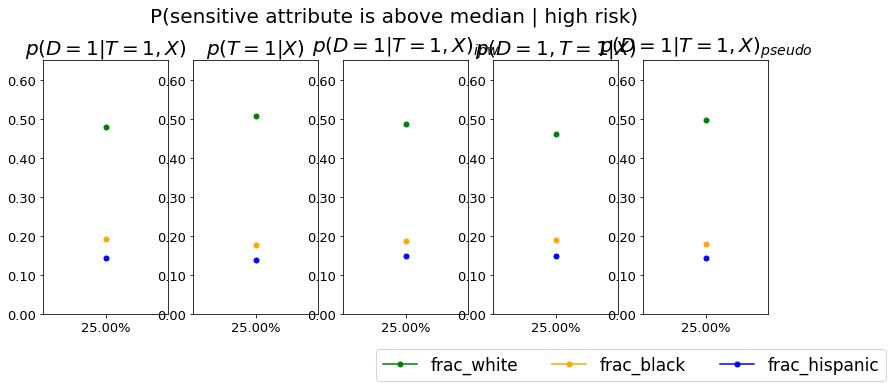

In [28]:
title=r'P(sensitive attribute is above median | high risk)'
equity_features=['frac_white', 'frac_black', 'frac_hispanic']
label_dict={'T': r'$p(T=1|X)$', 'D|T': r'$p(D=1|T=1,X)$', 
        'D_and_T':r'$p(D=1,T=1|X)$', 'D|T_ipw':r'$p(D=1|T=1,X)_{ipw}$', 
        'D_pseudo':r'$p(D=1|T=1,X)_{pseudo}$', 'product_T_D_given_T':r'$p(T=1|X)*p(D=1|T=1,X)$'}
df_equity = df_cleaned.iloc[test_idxs].copy()
# add a majority column based on all frac_races
df_equity['majority'] = df_equity[['frac_hispanic',
       'frac_white', 'frac_black', 'frac_native', 'frac_asian', 'frac_hawaiian_islander',
       'frac_other']].idxmax(axis="columns")
tasks=['D|T', 'T', 'D|T_ipw', 'D_and_T', 'D_pseudo' ]
models=['LGBM']
# k_range= np.arange(0.5,1.0,0.1)
k_range=[0.75]
fig= plt.figure(figsize=(13,5))
colors_map={'frac_black':'orange', 'frac_hispanic':'blue', 'frac_white':'green', 'avg_household_income':'red'}

specific_race_flag = False
for i, m in enumerate(models):
    df_probs = dict_df_probs[m].copy()
    fracs_Inspections={}
    for j, t in enumerate(tasks):
        ax = plt.subplot(len(models), len(tasks), i*len(tasks)+(j+1))
        probs=df_probs[t].values
        sorted_idxs = np.argsort(probs)[::-1]
        fracs_Inspections[t]={'frac_white':[], 'frac_black':[], 'frac_hispanic':[]}
        for a,p in enumerate(k_range):
            top_k_idxs = sorted_idxs[:int((1-p)*len(probs))]
            print(f"length of top {(1-p)*100}% records:{len(top_k_idxs)}")
            df_top_k_probs_ef = df_equity.iloc[top_k_idxs]
            len_top_k_idx_specific_race = len(df_top_k_probs_ef.loc[df_top_k_probs_ef['majority'].isin(equity_features)])
            if specific_race_flag:
                denominator = len_top_k_idx_specific_race
            else:
                denominator = len(top_k_idxs)
            for ef in equity_features:
#                 print(df_top_k_probs_ef[[ef, 'majority']])
                df_top_k_probs_above_majority = df_top_k_probs_ef.loc[df_top_k_probs_ef['majority']== ef] #df_equity[ef].quantile(q=0.5)]
                print(f"feature, median high risk, median all data: {ef, df_top_k_probs_ef[ef].quantile(q=0.5), df_equity[ef].quantile(q=0.5)}")
                fracs_Inspections[t][ef].append(len(df_top_k_probs_above_majority)/denominator)
        for ef in equity_features:
            ax.plot(["".join([str(f"{(1-p)*100:.2f}"), '%']) for p in k_range], 
                    fracs_Inspections[t][ef], marker='.', label=ef, color=colors_map[ef], markersize=10)
        ax.set_title(label_dict[t], fontsize=20)
        ax.tick_params(axis='y', labelsize=13)
        ax.tick_params(axis='x', labelsize=13)
        ax.set_ylim(0,0.65)
        ax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.2f'))
        sum_fracs=0.0
        for key, val in fracs_Inspections[t].items():
            sum_fracs += val[0]
        print(f"total sum:{sum_fracs}, length of top k:{denominator}")
plt.legend(fontsize=17, ncol=4, bbox_to_anchor=(-0.1, -0.2), loc='center')
# fig.tight_layout()
fig.subplots_adjust(top=0.83)
plt.suptitle(title, fontsize=20)
plt.show()
plt.close()

In [29]:
fracs_Inspections

{'D|T': {'frac_white': [0.4803051979017644],
  'frac_black': [0.19151168335717692],
  'frac_hispanic': [0.14315689079637578]},
 'T': {'frac_white': [0.5081545064377683],
  'frac_black': [0.17634716261325703],
  'frac_hispanic': [0.13896041964711492]},
 'D|T_ipw': {'frac_white': [0.48631378159275157],
  'frac_black': [0.18750596089651883],
  'frac_hispanic': [0.14763948497854076]},
 'D_and_T': {'frac_white': [0.46170720076299476],
  'frac_black': [0.1905579399141631],
  'frac_hispanic': [0.14849785407725322]},
 'D_pseudo': {'frac_white': [0.4967095851216023],
  'frac_black': [0.1797806390081068],
  'frac_hispanic': [0.1435383881735813]}}

median of logmedianhouseholdincome:11.298431894469925


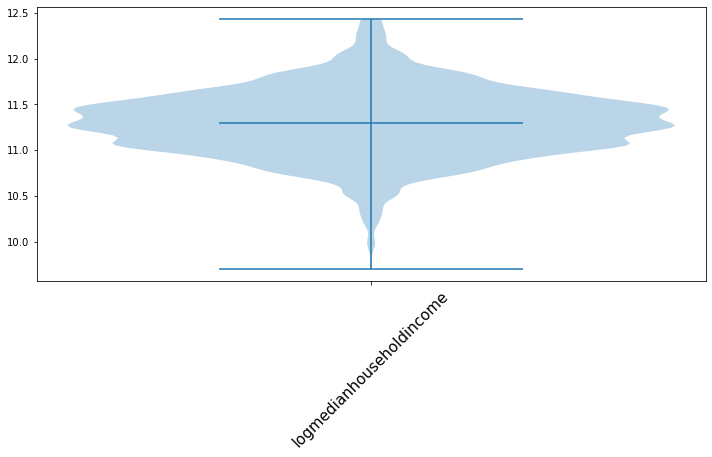

In [30]:
fig = plt.figure(figsize=figsize)
equity_features=['logmedianhouseholdincome']
true_high_risk=[]
ax=plt.subplot(1,1,1)
for i, ef in enumerate(equity_features):
    true_high_risk.append(df_equity[ef][df_equity['D']==1].values)
    print(f"median of {ef}:{df_equity[ef][df_equity['D']==1].median()}")
ax.violinplot(true_high_risk, showmeans=False, showmedians=True,showextrema=True)
ax.set_xticks(np.arange(1, len(equity_features) + 1), labels=equity_features, fontsize=15, rotation=45)
# ax.set_ylabel(title, fontsize=15)
fig.tight_layout()
fig.subplots_adjust(top=top_adjust)
# plt.suptitle(title)
plt.show()

In [31]:
import math
math.isclose(df_equity[['frac_hispanic', 'frac_white', 'frac_black', 'frac_native', 'frac_asian', 'frac_other','frac_hawaiian_islander']].values.sum(axis=1).all(), 1.0)


True

In [32]:
fracs_criminal = loadFile(osp.join(os.environ.get('OUT_PATH'), 'stop_and_frisk', 'sigmoid'), "fracs_sf.pkl")

In [33]:
mName='LGBM_w_feat_v2_cutoff_T'
path='_depth_7_subsample-data_1.0_subsample-feat_1.0'
df_medical = loadFile(osp.join(os.environ.get('USER_PATH'), 'HIRID_Repo', 'logs',
                               'benchmark_exp', str(mName), str(path)), "df_metrics_longTerm.csv")

In [34]:
def plotLongerOutcomes(df_medical, fracs_criminal, fracs_Inspections):

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
    #group by predicting the task. colName gives the task to be predicted. rowName gives the estimator name
#     medical_estimator = df_medical['rowName'].unique()
    medical_estimator = ['$p(T_{t=1hr}=1|X)$', '$p(D_{t=1hr}=1|T_{t=1hr}=1,X)$',
       '$IPW_{t=1hr}$', '$p(D_{t=1hr}=1,T_{t=1hr}=1|X)$', 'Pseudo Labels']
    width=0.35
    ax[0].bar(np.arange(3)-width,
              df_medical.loc[df_medical['rowName']==medical_estimator[0]]['PR'].values, width/2, label=medical_estimator[0])
    ax[0].bar(np.arange(3)-width/2, 
              df_medical.loc[df_medical['rowName']==medical_estimator[1]]['PR'].values, width/2, label=medical_estimator[1])
    ax[0].bar(np.arange(3), 
              df_medical.loc[df_medical['rowName']==medical_estimator[2]]['PR'].values, width/2, label=medical_estimator[2])
    ax[0].bar(np.arange(3)+width/2, 
              df_medical.loc[df_medical['rowName']==medical_estimator[3]]['PR'].values, width/2, label=medical_estimator[3])
    ax[0].bar(np.arange(3)+width, 
              df_medical.loc[df_medical['rowName']==medical_estimator[4]]['PR'].values, width/2, label=medical_estimator[4])
    ax[0].set_ylabel('Average Precision', fontsize=20)
    race_dict={'frac_white':'White', 'frac_black':'Black', 'frac_hispanic':'Hispanic'}
    race_labels=['Black', 'Hispanic', 'White']
    
    for task in ['T', 'D|T','D|T_ipw', 'D_and_T', 'D_pseudo' ]:
        for k in fracs_Inspections[task].keys():
            fracs_Inspections[task][race_dict[k]]=fracs_Inspections[task].pop(k)[0]
        for k in fracs_criminal[task].keys():
            fracs_criminal[task][k]=fracs_criminal[task][k][0]
    
    df_criminal = pd.DataFrame.from_dict(fracs_criminal)
    df_criminal['data']='criminal'
    print(df_criminal)
    ax[1].bar(np.arange(3)-width,
              df_criminal['T'].values, width/2, label=r'$\hat{p}(T=1|X)')
    ax[1].bar(np.arange(3)-width/2, 
              df_criminal['D|T'].values, width/2, label=r'$\hat{p}(Y=1|T=1,X)')
    ax[1].bar(np.arange(3), 
              df_criminal['D|T_ipw'].values, width/2, label=r'$\hat{p}(Y=1|T=1,X)')
    ax[1].bar(np.arange(3)+width/2, 
              df_criminal['D_and_T'].values, width/2, label=r'$\hat{p}(Y=1|T=1,X)')
    ax[1].bar(np.arange(3)+width, 
              df_criminal['D_pseudo'].values, width/2, label=r'$\hat{p}(Y=1|T=1,X)')
    ax[1].set_ylabel(r'Proportion among predicted' '\n' 'high-risk group', fontsize=20)
    ax[2].set_ylabel(r'Proportion among predicted' '\n' 'high-risk group', fontsize=20)
    df_inspections = pd.DataFrame.from_dict(fracs_Inspections)
    df_inspections['data']='inspections'
    print(df_inspections)
    df_inspections=df_inspections.reindex(df_criminal.index)
    print(df_inspections)
    ax[2].bar(np.arange(3)-width,
              df_inspections['T'].values, width/2, label=r'$\hat{p}(T=1|X)')
    ax[2].bar(np.arange(3)-width/2, 
              df_inspections['D|T'].values, width/2, label=r'$\hat{p}(Y=1|T=1,X)')
    ax[2].bar(np.arange(3), 
              df_inspections['D|T_ipw'].values, width/2, label=r'IPW')
    ax[2].bar(np.arange(3)+width/2, 
              df_inspections['D_and_T'].values, width/2, label=r'P(Y=1,T=1)')
    ax[2].bar(np.arange(3)+width, 
              df_inspections['D_pseudo'].values, width/2, label=r'Pseudo Labels')
    
#     ax[0].legend(labels=[r'$\hat{p}_T$', r'$\hat{p}_{Y_{T=1}}$'], fontsize=20)
    
#     ax[0].set_title('Healthcare', fontsize=20)
#     ax[1].set_title('Policing', fontsize=20)
#     ax[2].set_title('Inspections', fontsize=20)
    ax[0].set_xticks(np.arange(3))
    ax[0].set_xticklabels([r'$T_{t>1hr}$',
                           r'$Y|T_{t>1hr}$', r'$Mortality$'],
                          rotation=0, fontsize=15)
    ax[1].set_xticks(np.arange(3))
    ax[1].set_xticklabels(df_criminal.index, fontsize=15, style='italic')
    ax[2].set_xticks(np.arange(3))
    ax[2].set_xticklabels(df_inspections.index, fontsize=15, style='italic')
    ax[1].set_xlabel(r'$Pedestrians$', fontsize=17)
    ax[2].set_xlabel(r'$Neighbourhoods$', fontsize=17)
    ax[0].tick_params(axis='y', labelsize=15)
    ax[0].tick_params(axis='x', labelsize=15)
    ax[0].set_ylim(0,1)
    ax[1].legend(labels=[r'$\hat{p}_T$', r'$\hat{p}_{Y_{T=1}}$', r'$\hat{p}^{(IPW)}_{Y_{T=1}}$', r'$\hat{p}_{Y=1,T=1}$', r'$\hat{p}^{(pseudo)}_{Y}$'], fontsize=13)
#     ax[0].legend()
    for ax in [ax[1], ax[2]]:
        ax.set_ylim(0,0.65)
        ax.tick_params(axis='y', labelsize=15)
        ax.tick_params(axis='x', labelsize=15)
    
    fig.tight_layout() 
    plt.subplots_adjust(left=0.01, wspace=None, hspace=None)
    plt.show()
    plt.close()

                 T       D|T   D|T_ipw   D_and_T  D_pseudo      data
Black     0.613497  0.545537  0.567392  0.591352  0.599652  criminal
Hispanic  0.350853  0.344253  0.333430  0.342633  0.338093  criminal
White     0.035650  0.110211  0.099178  0.066015  0.062256  criminal
               D|T         T   D|T_ipw   D_and_T  D_pseudo         data
White     0.480305  0.508155  0.486314  0.461707  0.496710  inspections
Black     0.191512  0.176347  0.187506  0.190558  0.179781  inspections
Hispanic  0.143157  0.138960  0.147639  0.148498  0.143538  inspections
               D|T         T   D|T_ipw   D_and_T  D_pseudo         data
Black     0.191512  0.176347  0.187506  0.190558  0.179781  inspections
Hispanic  0.143157  0.138960  0.147639  0.148498  0.143538  inspections
White     0.480305  0.508155  0.486314  0.461707  0.496710  inspections


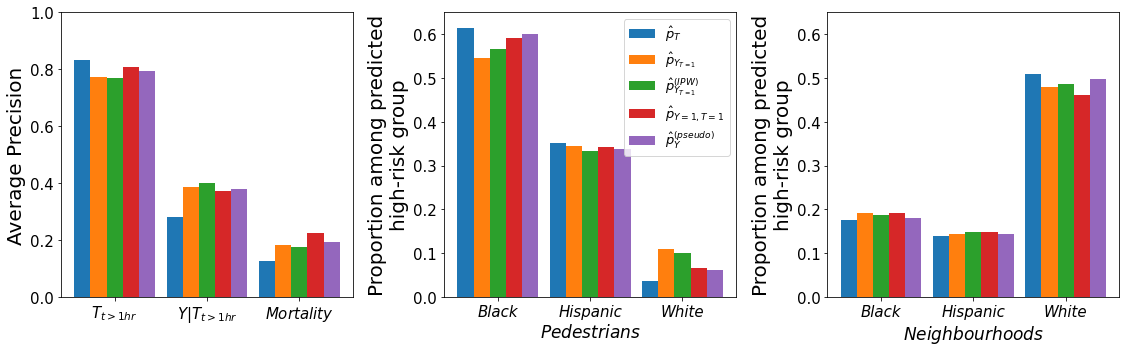

In [35]:
plotLongerOutcomes(df_medical.copy(), copy.deepcopy(fracs_criminal), copy.deepcopy(fracs_Inspections))

In [36]:
df_medical['rowName'].unique()

array(['$p(T_{t=1hr}=1|X)$', '$p(D_{t=1hr}=1|T_{t=1hr}=1,X)$',
       '$p(D_{t=1hr}=1,T_{t=1hr}=1|X)$', '$IPW_{t=1hr}$', 'Pseudo Labels'],
      dtype=object)

In [37]:
def plotLongerOutcomesMedical(df_medical, savefig_path=None):

    fig, ax = plt.subplots(figsize=(5,5))
    #group by predicting the task. colName gives the task to be predicted. rowName gives the estimator name
    medical_estimator = ['$p(T_{t=1hr}=1|X)$', '$p(D_{t=1hr}=1|T_{t=1hr}=1,X)$',
       '$IPW_{t=1hr}$', '$p(D_{t=1hr}=1,T_{t=1hr}=1|X)$', 'Pseudo Labels']
    width=0.35
    ax.bar(np.arange(3)-width,
              df_medical.loc[df_medical['rowName']==medical_estimator[0]]['PR'].values, width/2, label=medical_estimator[0])
    ax.bar(np.arange(3)-width/2, 
              df_medical.loc[df_medical['rowName']==medical_estimator[1]]['PR'].values, width/2, label=medical_estimator[1])
    ax.bar(np.arange(3), 
              df_medical.loc[df_medical['rowName']==medical_estimator[2]]['PR'].values, width/2, label=medical_estimator[2])
    ax.bar(np.arange(3)+width/2, 
              df_medical.loc[df_medical['rowName']==medical_estimator[3]]['PR'].values, width/2, label=medical_estimator[3])
    ax.bar(np.arange(3)+width, 
              df_medical.loc[df_medical['rowName']==medical_estimator[4]]['PR'].values, width/2, label=medical_estimator[4])
    ax.set_ylabel('Average Precision', fontsize=20)
    
   

    ax.set_ylabel('Average Precision', fontsize=20)
    
    ax.legend(labels=[r'$\hat{p}_T$', r'$\hat{p}_{Y_{T=1}}$', r'$\hat{p}^{(IPW)}_{Y_{T=1}}$', r'$\hat{p}_{Y=1,T=1}$', r'$\hat{p}^{(pseudo)}_{Y}$'], fontsize=13)
    ax.set_xticks(np.arange(3))
    ax.set_xticklabels([r'$T_{t>1hr}$',
                           r'$Y|T_{t>1hr}$', r'$Mortality$'],
                          rotation=0, fontsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.tick_params(axis='x', labelsize=15)
    ax.set_ylim(0,1)
    fig.tight_layout()
    if savefig_path is not None:
        plt.savefig(f"{''.join([savefig_path, '/HealthcareLongTerm.pdf'])}")
     
    plt.show()
    plt.close()

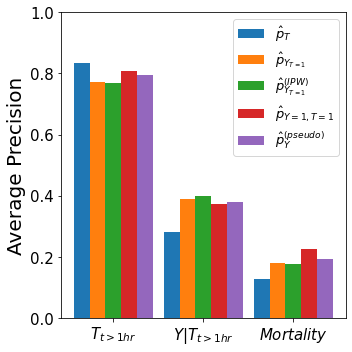

In [38]:
plotLongerOutcomesMedical(df_medical.copy(), savefig_path=processed_data_path)

In [39]:
processed_data_path

'/share/pierson/selective_labels_data/hirid_data_analysis/richras_dir/learning_from_doctor_and_patient/output_directory/ParksInspection/New_Dataset/sigmoid'

In [40]:
def plotLongerOutcomesPolicing(fracs_criminal, savefig_path=None):

    fig, ax = plt.subplots(figsize=(6,5))
    #group by predicting the task. colName gives the task to be predicted. rowName gives the estimator name
    width=0.35
    race_dict={'frac_white':'White', 'frac_black':'Black', 'frac_hispanic':'Hispanic'}
    race_labels=['Black', 'Hispanic', 'White']
    
    for task in ['T', 'D|T','D|T_ipw', 'D_and_T', 'D_pseudo' ]:
        for k in fracs_criminal[task].keys():
            fracs_criminal[task][k]=fracs_criminal[task][k][0]
    
    df_criminal = pd.DataFrame.from_dict(fracs_criminal)
    df_criminal['data']='criminal'
    print(df_criminal)
    ax.bar(np.arange(3)-width,
              df_criminal['T'].values, width/2, label=r'$\hat{p}(T=1|X)')
    ax.bar(np.arange(3)-width/2, 
              df_criminal['D|T'].values, width/2, label=r'$\hat{p}(Y=1|T=1,X)')
    ax.bar(np.arange(3), 
              df_criminal['D|T_ipw'].values, width/2, label=r'$\hat{p}(Y=1|T=1,X)')
    ax.bar(np.arange(3)+width/2, 
              df_criminal['D_and_T'].values, width/2, label=r'$\hat{p}(Y=1|T=1,X)')
    ax.bar(np.arange(3)+width, 
              df_criminal['D_pseudo'].values, width/2, label=r'$\hat{p}(Y=1|T=1,X)')
    ax.set_ylabel(r'Proportion among predicted' '\n' 'high-risk group', fontsize=20)
    ax.set_xticks(np.arange(3))
    ax.set_xticklabels(df_criminal.index, fontsize=15, style='italic')
    ax.set_xlabel(r'$Pedestrians$', fontsize=17)
    ax.set_ylim(0,0.65)
    ax.tick_params(axis='y', labelsize=15)
    ax.tick_params(axis='x', labelsize=15)
    
    fig.tight_layout() 
    if savefig_path is not None:
        plt.savefig(f"{''.join([savefig_path, '/PolicingEquity.pdf'])}")
    plt.show()
    plt.close()

                 T       D|T   D|T_ipw   D_and_T  D_pseudo      data
Black     0.613497  0.545537  0.567392  0.591352  0.599652  criminal
Hispanic  0.350853  0.344253  0.333430  0.342633  0.338093  criminal
White     0.035650  0.110211  0.099178  0.066015  0.062256  criminal


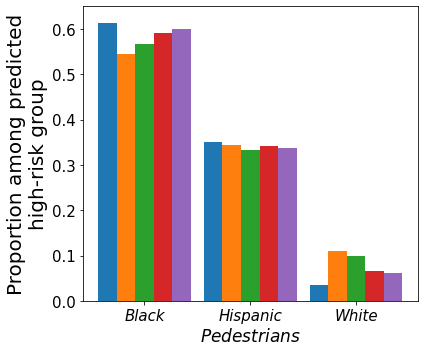

In [41]:
plotLongerOutcomesPolicing(copy.deepcopy(fracs_criminal), savefig_path=processed_data_path)

In [42]:
def plotLongerOutcomesInspections_2_est(fracs_Inspections, savefig_path=None):

    fig, ax = plt.subplots(figsize=(6,5))
    width=0.35
    race_dict={'frac_white':'White', 'frac_black':'Black', 'frac_hispanic':'Hispanic'}
    race_labels=['Black', 'Hispanic', 'White']
    
    for task in ['T', 'D|T']:
        for k in fracs_Inspections[task].keys():
            fracs_Inspections[task][race_dict[k]]=fracs_Inspections[task].pop(k)[0]
    
    ax.set_ylabel(r'Proportion among predicted' '\n' 'high-risk group', fontsize=20)
    df_inspections = pd.DataFrame.from_dict(fracs_Inspections)
    df_inspections['data']='inspections'
    print(df_inspections)
    df_inspections=df_inspections.reindex(race_labels)
    print(df_inspections)
    ax.bar(np.arange(3)-width/2,
              df_inspections['T'].values, width, label=r'$\hat{p}(T=1|X)')
    ax.bar(np.arange(3)+width/2, 
              df_inspections['D|T'].values, width, label=r'$\hat{p}(Y=1|T=1,X)')
    
    ax.set_xticks(np.arange(3))
    ax.set_xticklabels(df_inspections.index, fontsize=15, style='italic')
    ax.set_xlabel(r'$Neighbourhoods$', fontsize=17)
    

    ax.set_ylim(0,0.65)
    ax.tick_params(axis='y', labelsize=15)
    ax.tick_params(axis='x', labelsize=15)
    
    fig.tight_layout() 
    if savefig_path is not None:
        plt.savefig(f"{''.join([savefig_path, '/InspectionsEquity.pdf'])}")
    plt.show()
    plt.close()

                    D|T         T                D|T_ipw  \
White          0.480305  0.508155                    NaN   
Black          0.191512  0.176347                    NaN   
Hispanic       0.143157  0.138960                    NaN   
frac_white          NaN       NaN  [0.48631378159275157]   
frac_black          NaN       NaN  [0.18750596089651883]   
frac_hispanic       NaN       NaN  [0.14763948497854076]   

                             D_and_T              D_pseudo         data  
White                            NaN                   NaN  inspections  
Black                            NaN                   NaN  inspections  
Hispanic                         NaN                   NaN  inspections  
frac_white     [0.46170720076299476]  [0.4967095851216023]  inspections  
frac_black      [0.1905579399141631]  [0.1797806390081068]  inspections  
frac_hispanic  [0.14849785407725322]  [0.1435383881735813]  inspections  
               D|T         T D|T_ipw D_and_T D_pseudo        

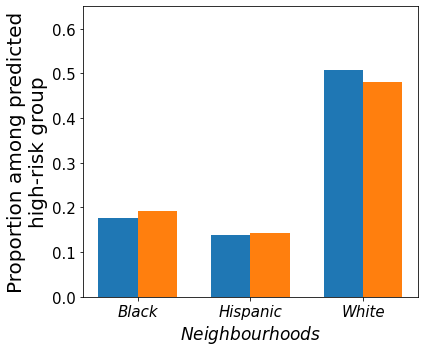

In [43]:
plotLongerOutcomesInspections_2_est(copy.deepcopy(fracs_Inspections), savefig_path=processed_data_path)

In [44]:
def plotLongerOutcomesInspections(fracs_Inspections, savefig_path=None):

    fig, ax = plt.subplots(figsize=(6,5))
    width=0.35
    race_dict={'frac_white':'White', 'frac_black':'Black', 'frac_hispanic':'Hispanic'}
    race_labels=['Black', 'Hispanic', 'White']
    
    for task in ['T', 'D|T','D|T_ipw', 'D_and_T', 'D_pseudo' ]:
        for k in fracs_Inspections[task].keys():
            fracs_Inspections[task][race_dict[k]]=fracs_Inspections[task].pop(k)[0]
    
    ax.set_ylabel(r'Proportion among predicted' '\n' 'high-risk group', fontsize=20)
    df_inspections = pd.DataFrame.from_dict(fracs_Inspections)
    df_inspections['data']='inspections'
    print(df_inspections)
    df_inspections=df_inspections.reindex(race_labels)
    print(df_inspections)
    ax.bar(np.arange(3)-width,
              df_inspections['T'].values, width/2, label=r'$\hat{p}(T=1|X)')
    ax.bar(np.arange(3)-width/2, 
              df_inspections['D|T'].values, width/2, label=r'$\hat{p}(Y=1|T=1,X)')
    ax.bar(np.arange(3), 
              df_inspections['D|T_ipw'].values, width/2, label=r'IPW')
    ax.bar(np.arange(3)+width/2, 
              df_inspections['D_and_T'].values, width/2, label=r'P(Y=1,T=1)')
    ax.bar(np.arange(3)+width, 
              df_inspections['D_pseudo'].values, width/2, label=r'Pseudo Labels')
    
    ax.set_xticks(np.arange(3))
    ax.set_xticklabels(df_inspections.index, fontsize=15, style='italic')
    ax.set_xlabel(r'$Neighbourhoods$', fontsize=17)
    

    ax.set_ylim(0,0.65)
    ax.tick_params(axis='y', labelsize=15)
    ax.tick_params(axis='x', labelsize=15)
    
    fig.tight_layout() 
    if savefig_path is not None:
        plt.savefig(f"{''.join([savefig_path, '/InspectionsEquity_all_estimators.pdf'])}")
    plt.show()
    plt.close()

               D|T         T   D|T_ipw   D_and_T  D_pseudo         data
White     0.480305  0.508155  0.486314  0.461707  0.496710  inspections
Black     0.191512  0.176347  0.187506  0.190558  0.179781  inspections
Hispanic  0.143157  0.138960  0.147639  0.148498  0.143538  inspections
               D|T         T   D|T_ipw   D_and_T  D_pseudo         data
Black     0.191512  0.176347  0.187506  0.190558  0.179781  inspections
Hispanic  0.143157  0.138960  0.147639  0.148498  0.143538  inspections
White     0.480305  0.508155  0.486314  0.461707  0.496710  inspections


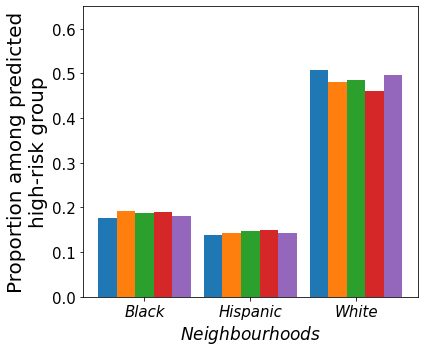

In [45]:
plotLongerOutcomesInspections(copy.deepcopy(fracs_Inspections), savefig_path=processed_data_path)